In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [9]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor # <-- Import the wrapper


In [10]:
train=pd.read_csv('../dataset/train_featured.csv')

In [11]:
test=pd.read_csv('../dataset/test_featured.csv')

In [12]:
train

,Component1_fraction,Component2_fraction,Component3_fraction,Component4_fraction,Component5_fraction,Component1_Property1,Component2_Property1,Component3_Property1,Component4_Property1,Component5_Property1,...,Component5_Prop_1_x_Fraction,Component5_Prop_2_x_Fraction,Component5_Prop_3_x_Fraction,Component5_Prop_4_x_Fraction,Component5_Prop_5_x_Fraction,Component5_Prop_6_x_Fraction,Component5_Prop_7_x_Fraction,Component5_Prop_8_x_Fraction,Component5_Prop_9_x_Fraction,Component5_Prop_10_x_Fraction
0,0.21,0.00,0.42,0.25,0.12,-0.021782,1.981251,0.020036,0.140315,1.032029,...,0.123843,0.025934,-0.369953,-0.169206,0.035606,0.208956,0.026548,0.061599,-0.076367,-0.327471
1,0.02,0.33,0.19,0.46,0.00,-0.224339,1.148036,-1.107840,0.149533,-0.354000,...,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.08,0.08,0.18,0.50,0.16,0.457763,0.242591,-0.922492,0.908213,0.972003,...,0.155521,-0.108521,0.230064,-0.007537,-0.488454,0.293861,-0.106395,0.166308,0.019813,-0.067890
3,0.25,0.42,0.00,0.07,0.26,-0.577734,-0.930826,0.815284,0.447514,0.455717,...,0.118486,0.053903,-0.347874,-0.252382,0.277352,-0.067915,-0.025092,-0.331107,-0.253182,-0.149872
4,0.26,0.16,0.08,0.50,0.00,0.120415,0.666268,-0.626934,2.725357,0.392259,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.50,0.12,0.00,0.26,0.12,0.279523,-0.054170,-0.391227,0.400222,1.032029,...,0.123843,0.152777,0.080635,-0.303384,0.149685,-0.007602,0.132469,0.001480,0.091998,0.076943
1996,0.19,0.31,0.00,0.37,0.13,-0.887185,0.610050,0.178606,1.083154,-2.822749,...,-0.366957,0.124486,-0.026678,-0.074217,-0.029339,0.110352,-0.129036,-0.067662,-0.329877,0.051643
1997,0.38,0.06,0.14,0.31,0.11,0.568978,-0.196759,-0.646318,-0.980070,1.032029,...,0.113523,-0.116252,0.061164,0.027390,0.072859,0.084863,-0.065236,0.176359,0.172434,-0.031314
1998,0.50,0.16,0.00,0.18,0.16,-0.067453,0.321977,-0.137535,0.238507,0.017455,...,0.002793,0.081606,-0.027888,-0.170876,0.115188,-0.347358,0.108605,-0.115872,-0.025832,0.030961


In [13]:
feature_columns = train.columns
target_columns = [col for col in train.columns if 'BlendProperty' in col]
feature_columns=train.columns.drop(target_columns)

In [14]:
feature_columns=train.columns.drop(target_columns)

In [15]:
feature_columns

Index(['Component1_fraction', 'Component2_fraction', 'Component3_fraction',
       'Component4_fraction', 'Component5_fraction', 'Component1_Property1',
       'Component2_Property1', 'Component3_Property1', 'Component4_Property1',
       'Component5_Property1',
       ...
       'Component5_Prop_1_x_Fraction', 'Component5_Prop_2_x_Fraction',
       'Component5_Prop_3_x_Fraction', 'Component5_Prop_4_x_Fraction',
       'Component5_Prop_5_x_Fraction', 'Component5_Prop_6_x_Fraction',
       'Component5_Prop_7_x_Fraction', 'Component5_Prop_8_x_Fraction',
       'Component5_Prop_9_x_Fraction', 'Component5_Prop_10_x_Fraction'],
      dtype='object', length=105)

In [16]:
X_train = train[feature_columns]
y_train = train[target_columns]
X_test=test[feature_columns]

In [17]:
print("Final training data shapes:")
print("X_train_full:", X_train.shape)
print("y_train_full (original):", y_train.shape)
print("X_test:", X_test.shape)
print("-" * 30)

Final training data shapes:
X_train_full: (2000, 105)
y_train_full (original): (2000, 10)
X_test: (500, 105)
------------------------------


In [18]:

# --- Step 2: Define Evaluation Functions (as you provided) ---

def calculate_mape(y_true, y_pred):
    """Use sklearn's MAPE implementation."""
    return mean_absolute_percentage_error(y_true, y_pred)

def calculate_leaderboard_score(mape_cost, leaderboard_type='public'):
    """Leaderboard score: max[10, 100 - (90 × MAPE / Ref Cost)]"""
    ref_cost = 2.72 # Public leaderboard reference cost
    score = max(10, 100 - (90 * mape_cost) / ref_cost)
    return score

def evaluate_model(y_true, y_pred, leaderboard_type='public'):
    """Evaluate model using MAPE and leaderboard score."""
    # Note: sklearn's MAPE calculates the average error across all outputs, which is what we need.
    mape = calculate_mape(y_true, y_pred)
    score = calculate_leaderboard_score(mape, leaderboard_type)
    return score

def adjusted_r2(r2, n, p):
    """Calculates Adjusted R-squared."""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


In [19]:
def log_cosh_obj(y_true, y_pred):
    """
    Log-Cosh objective function. It's twice differentiable and less sensitive to outliers.
    It works like MSE for small errors and like log(MAE) for large errors.
    """
    # Ensure y_true and y_pred are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    x = y_pred - y_true
    grad = np.tanh(x)
    hess = 1 - np.tanh(x)**2
    return grad, hess

In [21]:

# --- Step 3: Set up K-Fold Cross-Validation ---
N_SPLITS = 10
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)


In [22]:
# Lists to store scores from each fold
train_adj_r2_scores = []
val_adj_r2_scores = []
val_leaderboard_scores = []


In [23]:

print(f"Starting {N_SPLITS}-Fold Cross-Validation...")
print("-" * 60)

# --- Step 4: Loop Through Each Fold ---
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"Fold {fold+1}/{N_SPLITS}")
    
    # Split the data for the current fold
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Initialize the model (it's good practice to re-initialize for each fold)
    base_lgbm = LGBMRegressor(
    objective='mape',  # Use the custom log-cosh objective function
    n_estimators=2000,
    learning_rate=0.01,
    num_leaves=31,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

    model = MultiOutputRegressor(estimator=base_lgbm, n_jobs=-1)
    # Train the model
    model.fit(X_train_fold, y_train_fold)

    # --- Evaluate on Training Data for this Fold ---
    y_train_pred = model.predict(X_train_fold)
    # R2_score for multi-output returns the average R2
    train_r2 = r2_score(y_train_fold, y_train_pred) 
    train_adj_r2 = adjusted_r2(train_r2, n=X_train_fold.shape[0], p=X_train_fold.shape[1])
    train_adj_r2_scores.append(train_adj_r2)

    # --- Evaluate on Validation Data for this Fold ---
    y_val_pred = model.predict(X_val_fold)
    val_r2 = r2_score(y_val_fold, y_val_pred)
    val_adj_r2 = adjusted_r2(val_r2, n=X_val_fold.shape[0], p=X_val_fold.shape[1])
    val_adj_r2_scores.append(val_adj_r2)

    # Calculate the custom leaderboard score for the validation set
    leaderboard_score = evaluate_model(y_val_fold, y_val_pred)
    val_leaderboard_scores.append(leaderboard_score)

    # Print results for the current fold
    print(f"  Train Adjusted R²:   {train_adj_r2:.4f}")
    print(f"  Validation Adjusted R²: {val_adj_r2:.4f}")
    print(f"  Validation Leaderboard Score: {leaderboard_score:.4f}")
    print("-" * 30)


Starting 10-Fold Cross-Validation...
------------------------------------------------------------
Fold 1/10
  Train Adjusted R²:   0.9701
  Validation Adjusted R²: 0.8539
  Validation Leaderboard Score: 10.0000
------------------------------
Fold 2/10
  Train Adjusted R²:   0.9704
  Validation Adjusted R²: 0.8671
  Validation Leaderboard Score: 62.1881
------------------------------
Fold 3/10
  Train Adjusted R²:   0.9688
  Validation Adjusted R²: 0.8726
  Validation Leaderboard Score: 75.8427
------------------------------
Fold 4/10
  Train Adjusted R²:   0.9687
  Validation Adjusted R²: 0.8832
  Validation Leaderboard Score: 64.3053
------------------------------
Fold 5/10
  Train Adjusted R²:   0.9698
  Validation Adjusted R²: 0.8775
  Validation Leaderboard Score: 34.0989
------------------------------
Fold 6/10
  Train Adjusted R²:   0.9697
  Validation Adjusted R²: 0.8625
  Validation Leaderboard Score: 76.3100
------------------------------
Fold 7/10
  Train Adjusted R²:   0.968

In [24]:
# Define the base single-output model with your best parameters
final_base_lgbm = LGBMRegressor(
    objective='mape',          # Use MAPE as the objective function
    n_estimators=4000,          # Use a slightly higher number for the final model
    learning_rate=0.01,
    num_leaves=31,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,        # Use a fixed random state for a reproducible final model
    n_jobs=-1,
    verbose=-1
)

In [25]:
# Wrap the base model with MultiOutputRegressor
final_model = MultiOutputRegressor(estimator=final_base_lgbm, n_jobs=-1)

In [26]:
# --- Step 3: Train the Model on the ENTIRE Training Dataset ---
print("Training the final model on all 2000 rows...")
final_model.fit(X_train, y_train)
print("Final model training complete.")
print("-" * 30)

Training the final model on all 2000 rows...
Final model training complete.
------------------------------


In [28]:
print("Making predictions on the test data...")
final_predictions = final_model.predict(X_test)

Making predictions on the test data...


In [29]:
final_predictions

array([[ 0.0894974 ,  0.15362731,  0.65481622, ...,  0.47548917,
        -0.5224989 ,  0.39509227],
       [-0.70026222, -0.82506596, -1.11396771, ..., -1.16805334,
        -0.58516708, -0.0370787 ],
       [ 1.37893461,  0.98346844,  0.9333727 , ...,  1.35260961,
         0.13980732,  1.98905595],
       ...,
       [ 1.58027863,  1.48894377,  0.04218799, ...,  1.07695891,
         0.31517645,  0.33263285],
       [-0.06066364,  0.50066546,  1.44406578, ...,  0.43051516,
        -0.04287832,  1.01538733],
       [-0.89477167, -1.77505886, -1.96033942, ..., -1.73763688,
        -2.1112637 , -0.25116087]])

In [30]:
type(final_predictions)

numpy.ndarray

In [31]:
# First, create the list of new column names
target_columns = [f'BlendProperty{i}' for i in range(1, 11)]

# Create a copy to avoid modifying your original 'test' DataFrame
test_with_predictions = test.copy()

# Directly assign the NumPy array to the new columns
# Pandas is smart enough to map the columns of the array to the new column names.
test_with_predictions[target_columns] = final_predictions


# --- 3. Verify the Result ---
print("Shape of the new combined DataFrame:", test_with_predictions.shape)
print("\nTop 5 rows of the combined DataFrame:")


Shape of the new combined DataFrame: (500, 116)

Top 5 rows of the combined DataFrame:


In [32]:
test_with_predictions.head()

,ID,Component1_fraction,Component2_fraction,Component3_fraction,Component4_fraction,Component5_fraction,Component1_Property1,Component2_Property1,Component3_Property1,Component4_Property1,...,BlendProperty1,BlendProperty2,BlendProperty3,BlendProperty4,BlendProperty5,BlendProperty6,BlendProperty7,BlendProperty8,BlendProperty9,BlendProperty10
0,1,0.18,0.05,0.32,0.37,0.08,-0.177804,-0.741219,0.769821,-0.877069,...,0.089497,0.153627,0.654816,0.286370,0.352849,0.774441,0.647265,0.475489,-0.522499,0.395092
1,2,0.00,0.50,0.00,0.37,0.13,2.501354,0.177344,-0.498739,-0.196742,...,-0.700262,-0.825066,-1.113968,-0.203144,-0.725035,-0.133914,-1.101990,-1.168053,-0.585167,-0.037079
2,3,0.16,0.00,0.17,0.50,0.17,1.547324,0.891479,0.030627,-0.368678,...,1.378935,0.983468,0.933373,0.784210,2.205087,1.112296,0.828479,1.352610,0.139807,1.989056
3,4,0.50,0.00,0.17,0.16,0.17,-0.424427,1.016862,-1.182979,-0.854225,...,-0.228161,0.488349,0.735651,-0.341791,1.819366,-0.203567,0.700269,0.789501,0.926497,-0.933545
4,5,0.00,0.00,0.50,0.50,0.00,-0.187062,-0.762173,-0.473660,2.074087,...,-0.060991,-0.944654,1.182058,0.326368,1.893887,0.412084,1.173378,0.248050,-0.592861,0.971362


In [33]:
test_with_predictions=test_with_predictions[['ID']+target_columns]

In [34]:
test_with_predictions

,ID,BlendProperty1,BlendProperty2,BlendProperty3,BlendProperty4,BlendProperty5,BlendProperty6,BlendProperty7,BlendProperty8,BlendProperty9,BlendProperty10
0,1,0.089497,0.153627,0.654816,0.286370,0.352849,0.774441,0.647265,0.475489,-0.522499,0.395092
1,2,-0.700262,-0.825066,-1.113968,-0.203144,-0.725035,-0.133914,-1.101990,-1.168053,-0.585167,-0.037079
2,3,1.378935,0.983468,0.933373,0.784210,2.205087,1.112296,0.828479,1.352610,0.139807,1.989056
3,4,-0.228161,0.488349,0.735651,-0.341791,1.819366,-0.203567,0.700269,0.789501,0.926497,-0.933545
4,5,-0.060991,-0.944654,1.182058,0.326368,1.893887,0.412084,1.173378,0.248050,-0.592861,0.971362
...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.208465,-0.907103,0.995190,-0.349545,-0.250234,-0.842001,0.971035,-0.401415,-1.244850,-0.483075
496,497,-1.507209,-1.048570,-0.976957,-1.882998,-0.625115,-1.787634,-0.961542,-1.574709,-1.051209,-1.204974
497,498,1.580279,1.488944,0.042188,0.534221,0.047345,0.329537,0.032062,1.076959,0.315176,0.332633
498,499,-0.060664,0.500665,1.444066,-0.739093,-0.943176,-0.121406,1.418811,0.430515,-0.042878,1.015387


In [35]:
test_with_predictions.to_csv('../submission/lightGBM_mape.csv',index=False)

In [36]:
import matplotlib.pyplot as plt

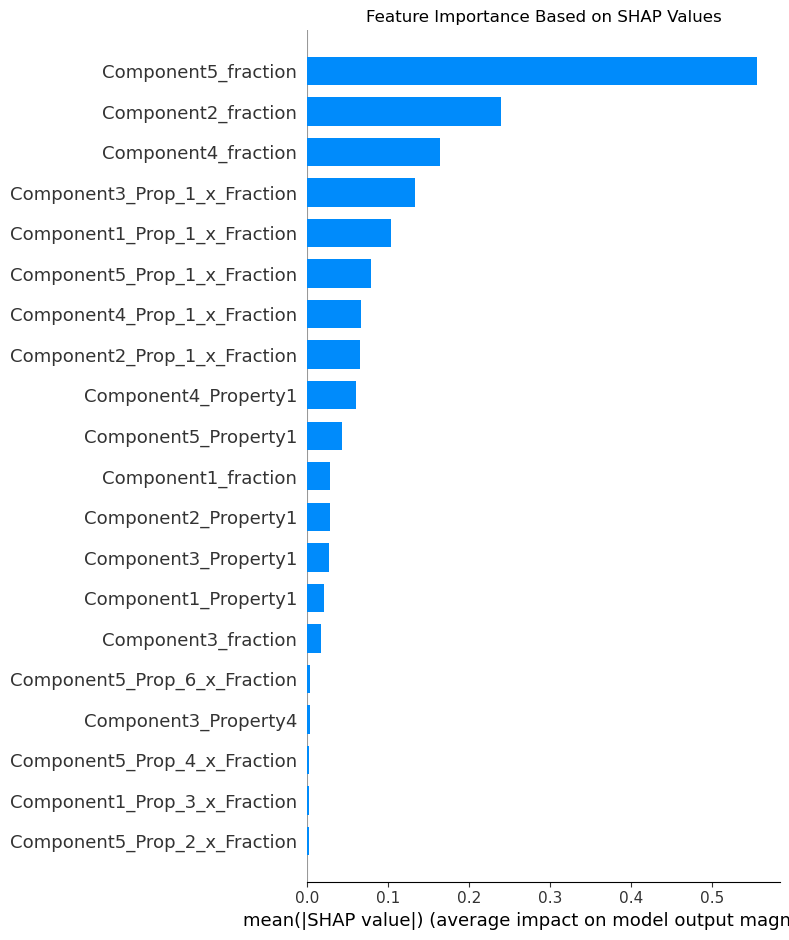


Top 20 Most Important Features:
                         Feature  SHAP_Importance
0            Component5_fraction         0.555799
1            Component2_fraction         0.239175
2            Component4_fraction         0.164721
3   Component3_Prop_1_x_Fraction         0.132859
4   Component1_Prop_1_x_Fraction         0.103843
5   Component5_Prop_1_x_Fraction         0.079002
6   Component4_Prop_1_x_Fraction         0.066628
7   Component2_Prop_1_x_Fraction         0.065707
8           Component4_Property1         0.060663
9           Component5_Property1         0.042837
10           Component1_fraction         0.029168
11          Component2_Property1         0.028670
12          Component3_Property1         0.027816
13          Component1_Property1         0.021732
14           Component3_fraction         0.017956
15  Component5_Prop_6_x_Fraction         0.004249
16          Component3_Property4         0.003385
17  Component5_Prop_4_x_Fraction         0.003207
18  Component1_Pr

In [37]:
import shap

# Initialize the SHAP explainer with the first estimator (since we're using MultiOutputRegressor)
explainer = shap.TreeExplainer(final_model.estimators_[0])

# Calculate SHAP values for the first target (you can repeat for other targets if needed)
shap_values = explainer.shap_values(X_test)

# Create bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Feature Importance Based on SHAP Values")
plt.tight_layout()
plt.show()

# Create DataFrame with feature importance scores
feature_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Importance': np.abs(shap_values).mean(0)
})

# Sort by importance
feature_importance = feature_importance.sort_values('SHAP_Importance', ascending=False).reset_index(drop=True)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

In [42]:
feature_importance[feature_importance['SHAP_Importance']<0.0005]

,Feature,SHAP_Importance
97,Component4_Prop_10_x_Fraction,0.000474
98,Component4_Property9,0.000458
99,Component2_Property2,0.000431
100,Component4_Property2,0.000415
101,Component1_Property5,0.000402
102,Component4_Prop_5_x_Fraction,0.000401
103,Component5_Property10,0.000388
104,Component1_Property6,0.000385


In [57]:
feature_importance[feature_importance['SHAP_Importance']<0.001]['Feature'].to_list()

['Component3_Property10',
 'Component2_Property9',
 'Component2_Property7',
 'Component5_Property4',
 'Component4_Property3',
 'Component3_Property6',
 'Component5_Property9',
 'Component4_Property6',
 'Component3_Prop_5_x_Fraction',
 'Component1_Property2',
 'Component4_Property8',
 'Component3_Prop_9_x_Fraction',
 'Component2_Property8',
 'Component1_Property8',
 'Component4_Property10',
 'Component4_Prop_9_x_Fraction',
 'Component4_Property4',
 'Component5_Property8',
 'Component4_Prop_4_x_Fraction',
 'Component3_Property9',
 'Component4_Prop_6_x_Fraction',
 'Component4_Prop_3_x_Fraction',
 'Component1_Property3',
 'Component3_Property8',
 'Component3_Prop_7_x_Fraction',
 'Component2_Property5',
 'Component4_Prop_7_x_Fraction',
 'Component5_Property6',
 'Component2_Property10',
 'Component3_Prop_8_x_Fraction',
 'Component4_Prop_2_x_Fraction',
 'Component1_Property4',
 'Component2_Property4',
 'Component4_Property7',
 'Component4_Property5',
 'Component5_Property5',
 'Component4_Prop